<a href="https://colab.research.google.com/github/coronarita1991/AIFFEL_RESEARCH_STUDY/blob/main/Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

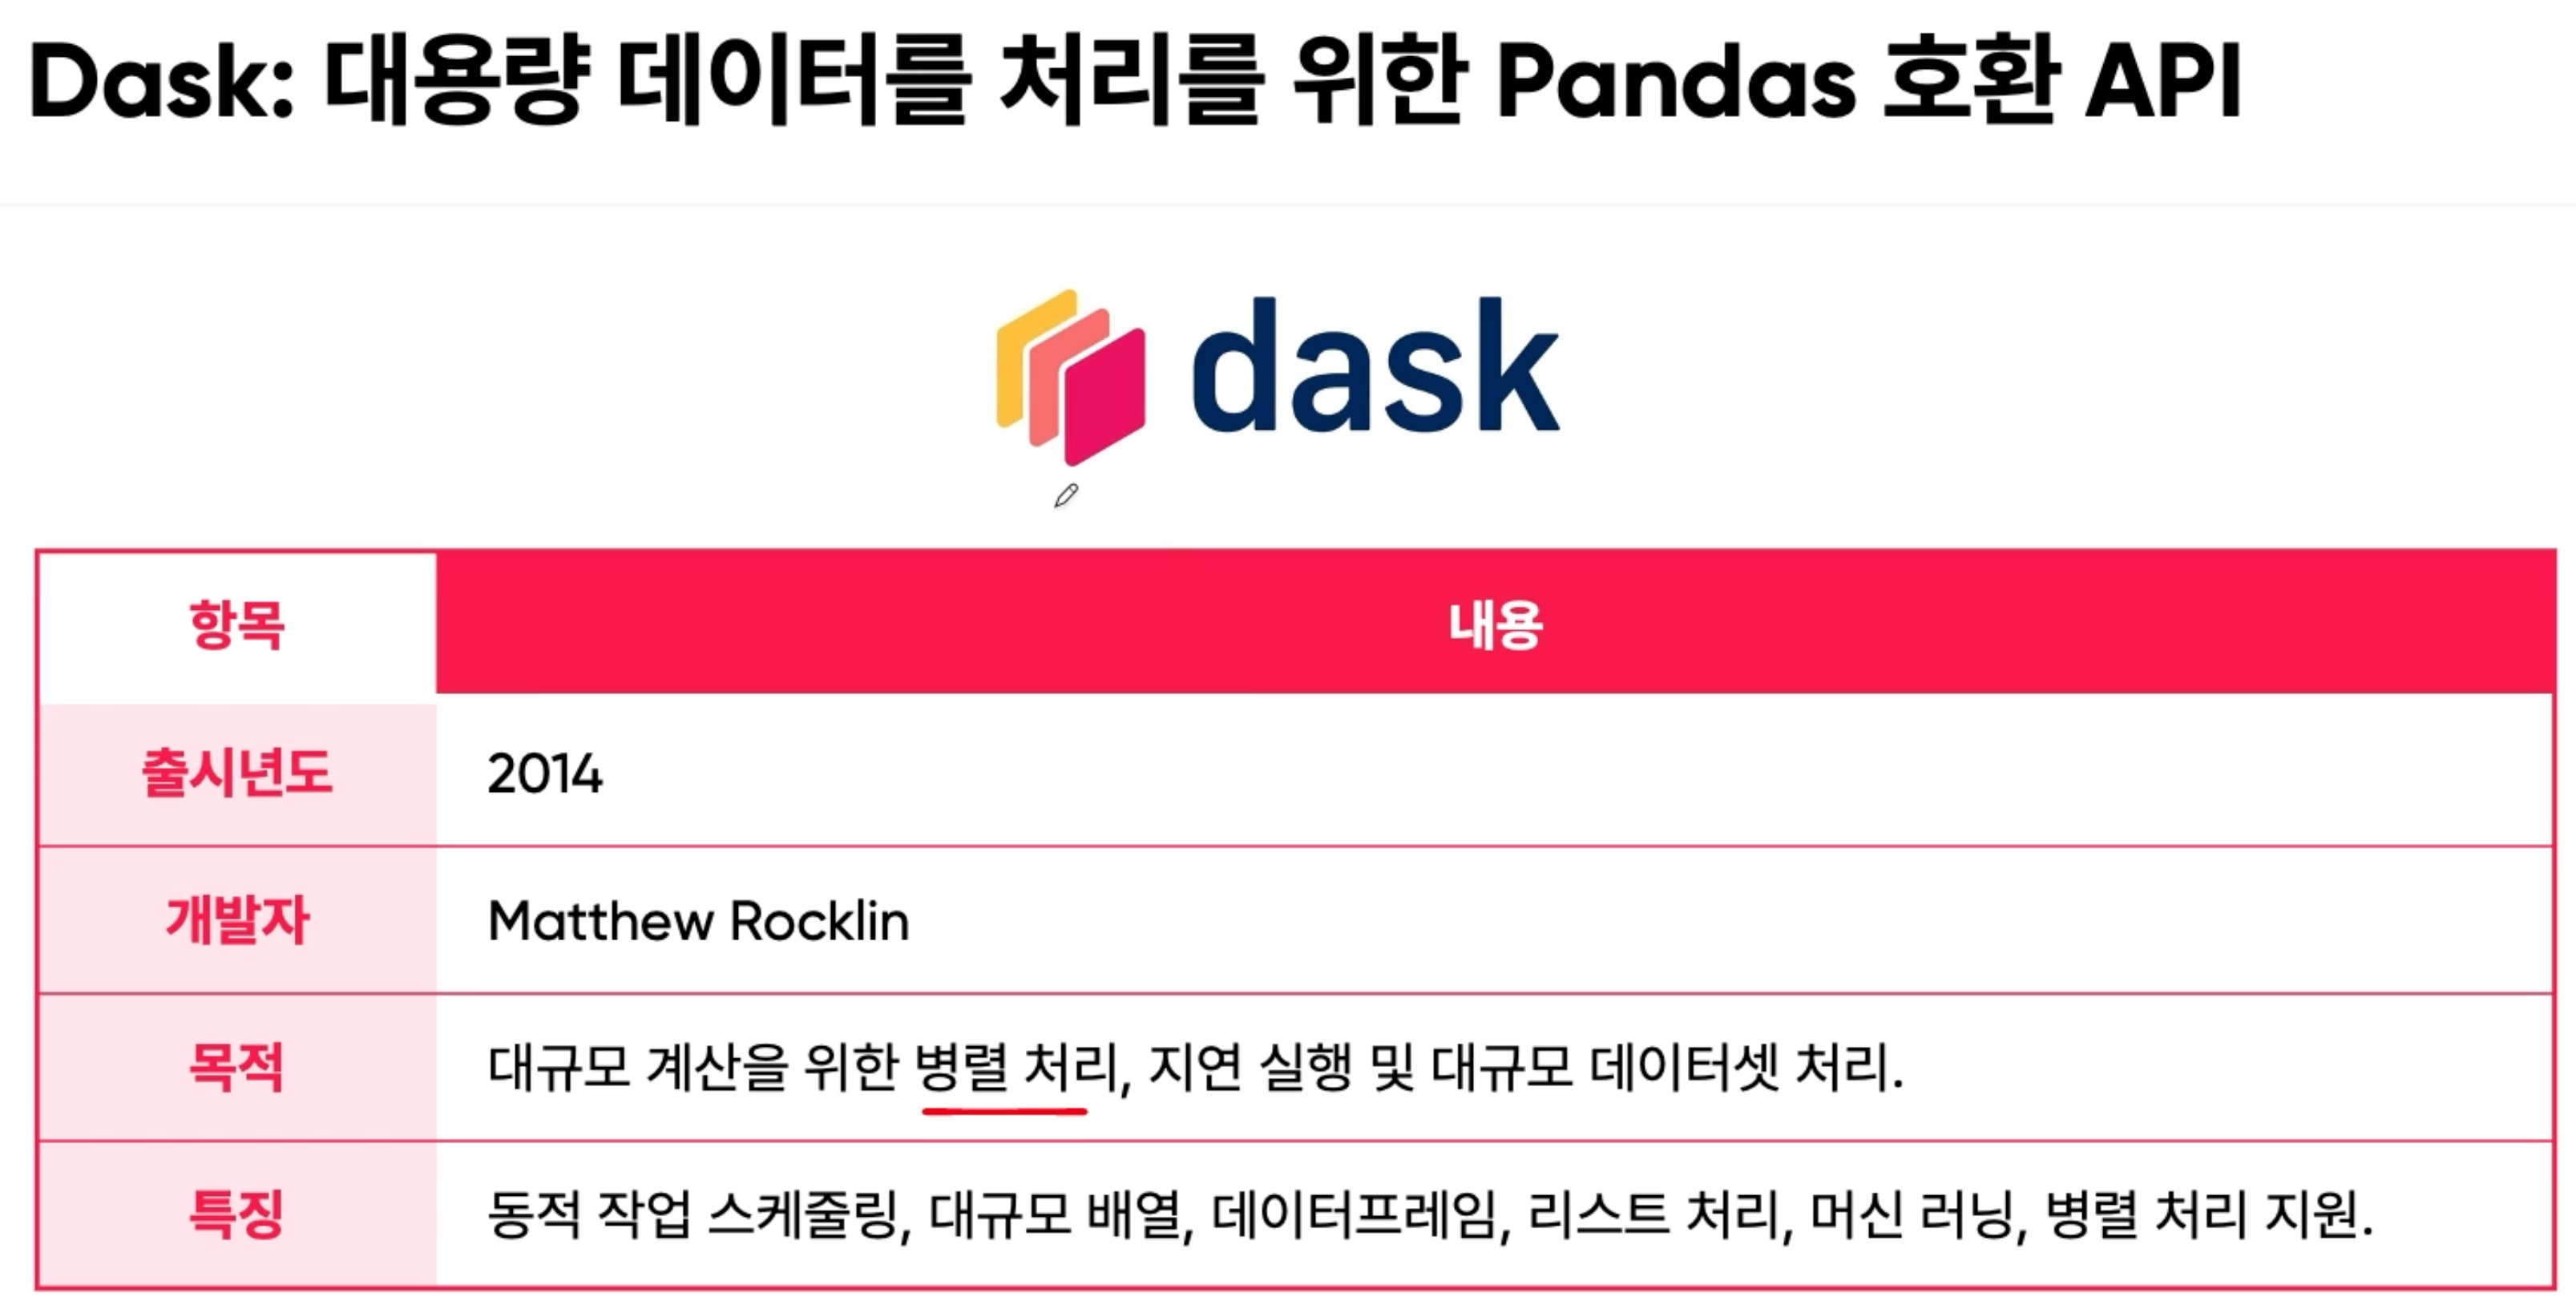

- Pandas API와 호환이 되어서 자연스럽게 사용이 가능함.

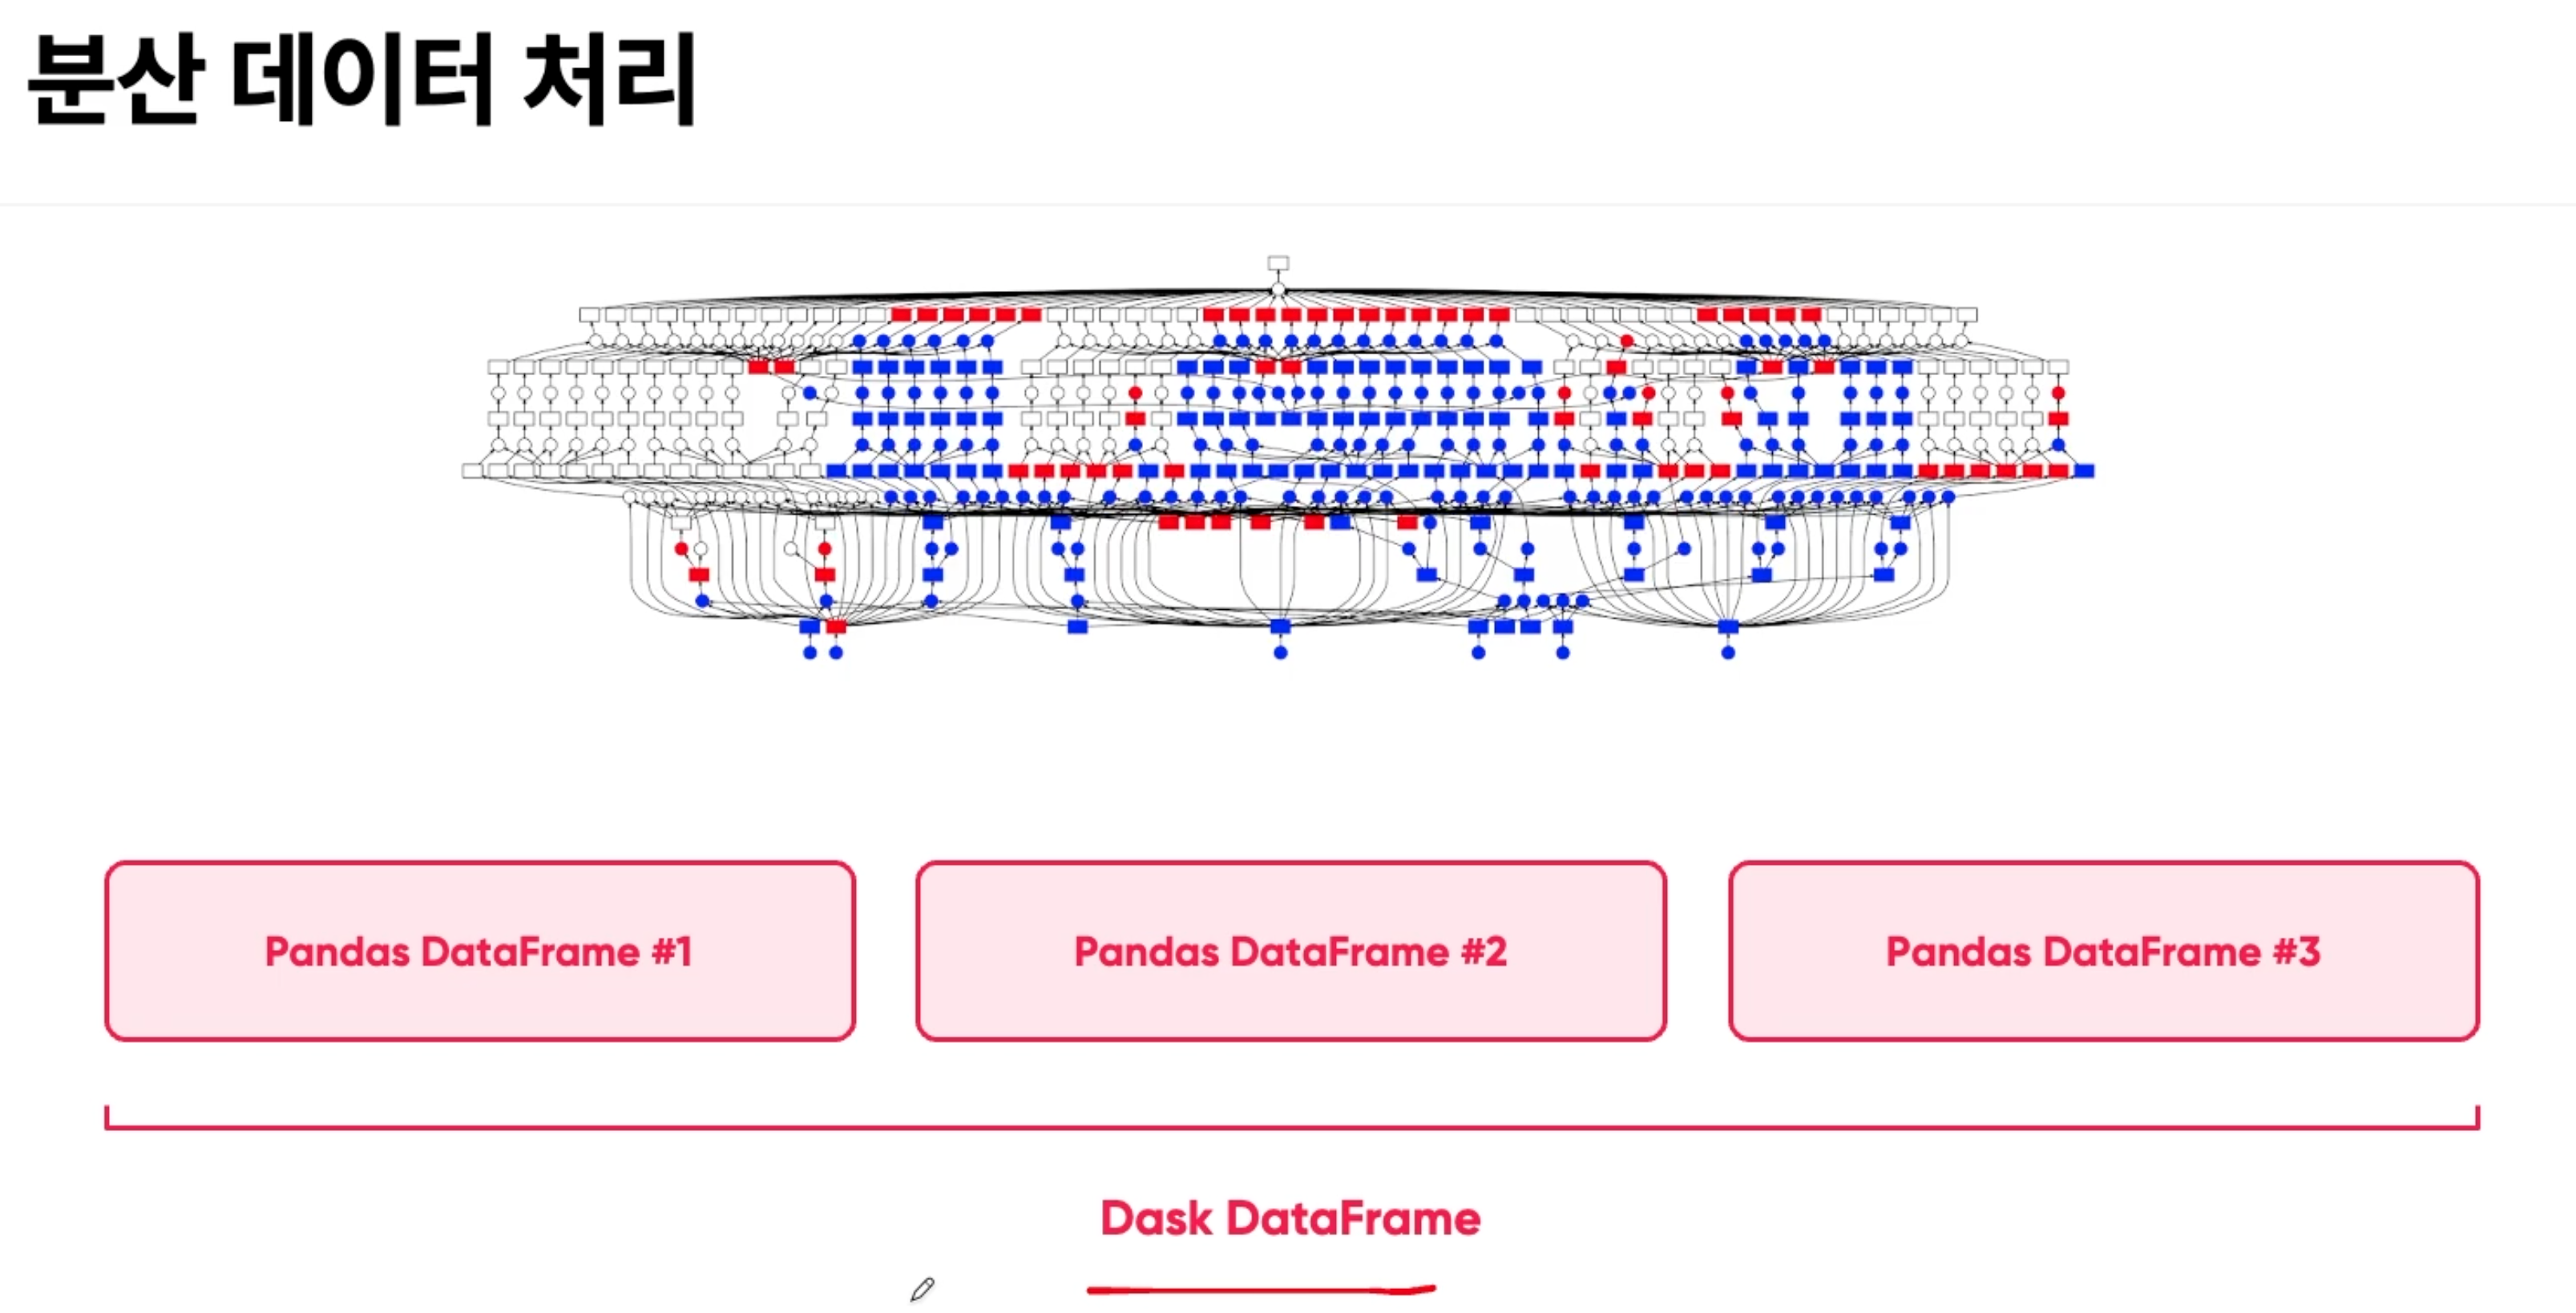

- Task를 chunk단위로 처리한 다음 다시 집계함

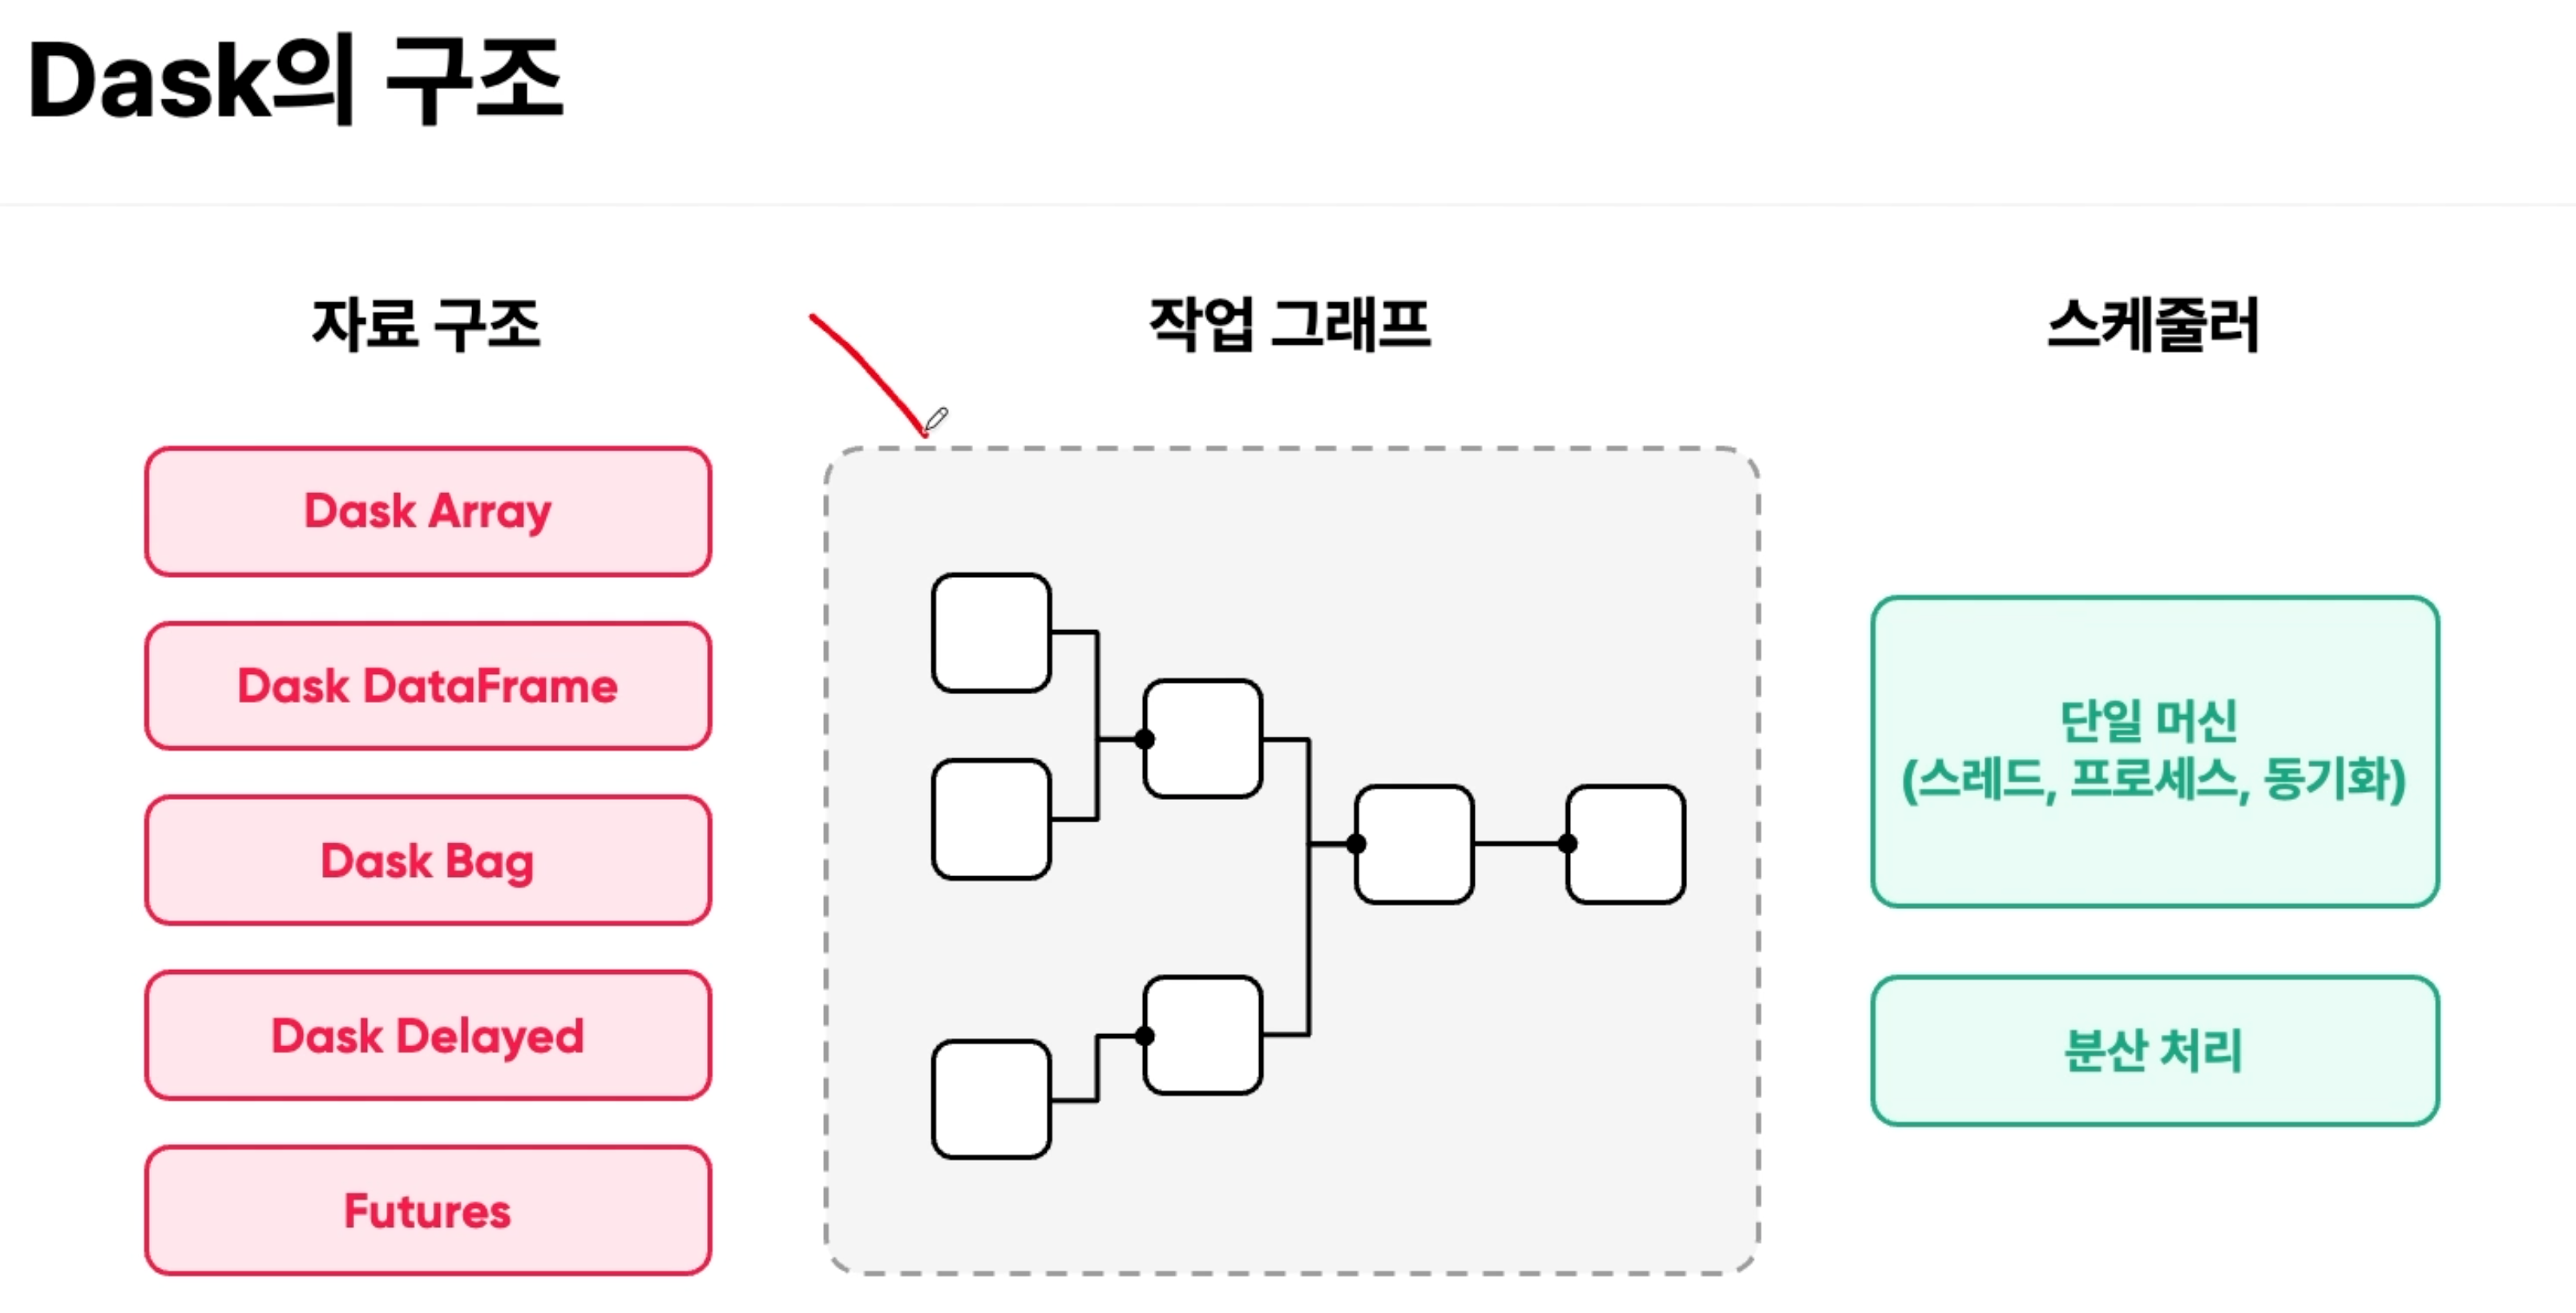

- 여러개의 worker 서버가 돌 때, 분산처리가 가능함. 빅데이터 spark, hadoop hive map reduce 등 복잡한데, Dask는 기본적으로 Dataframe를 쓰면 알아서 다 해준다.

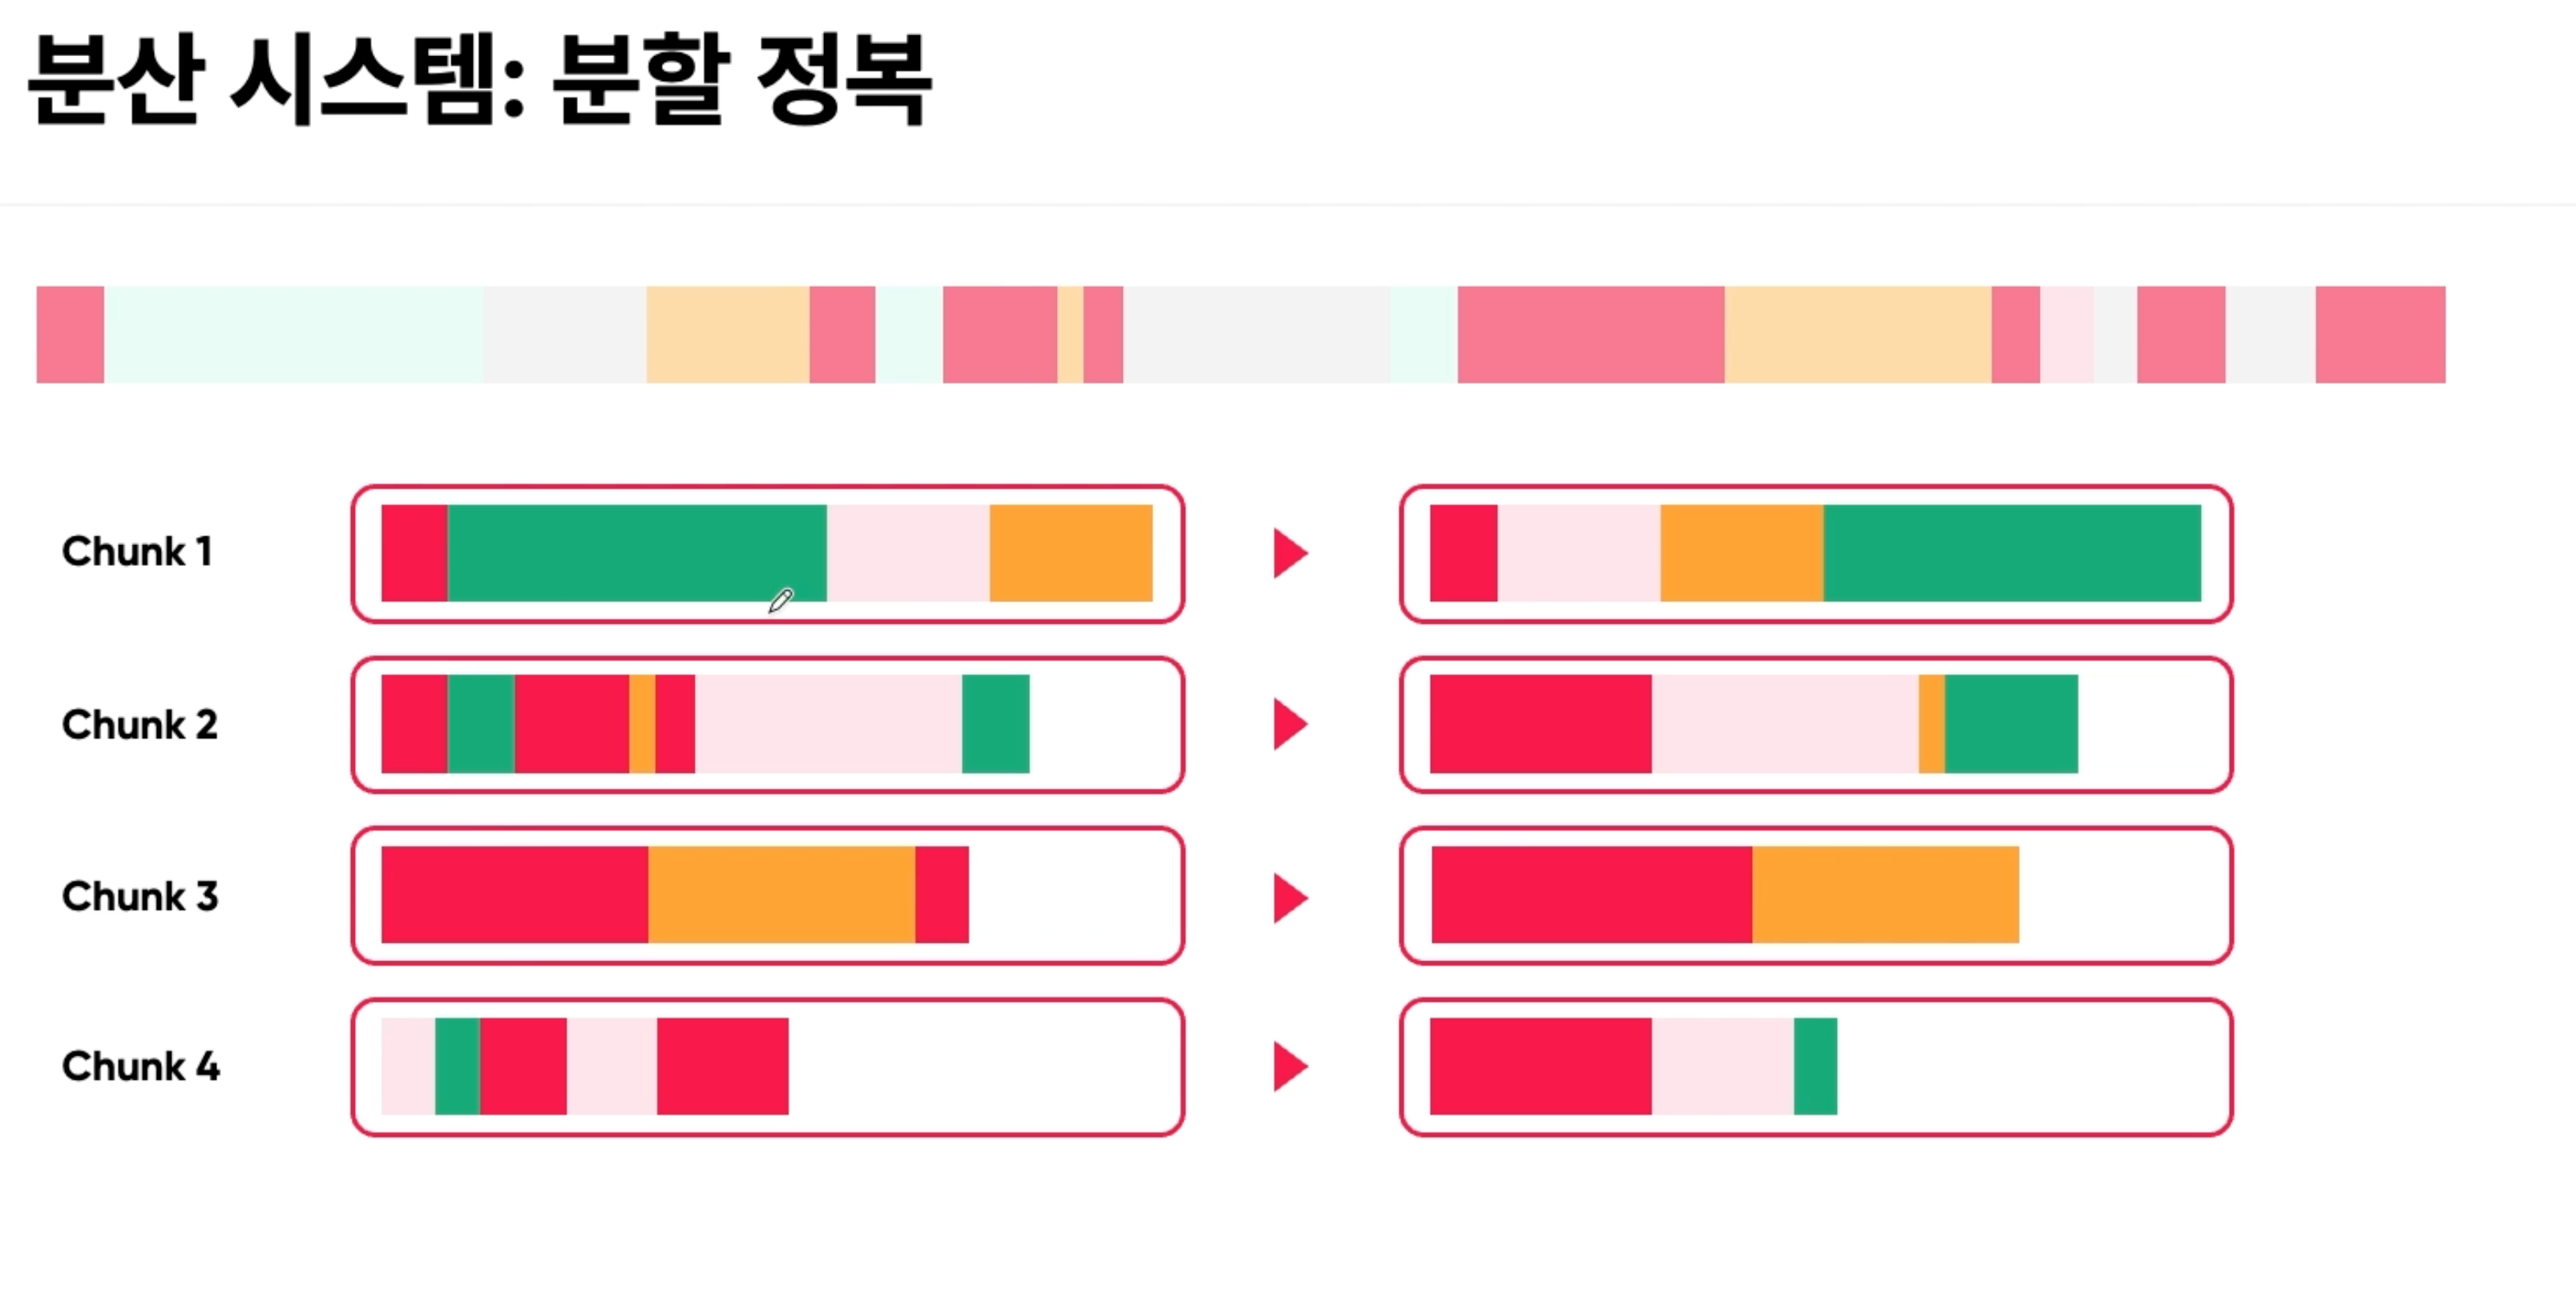

- 각각을 worker에 나눠서 일을 시키게 되면 ?
- 다시 모아서 합쳐주게 되면 됨.

- 데이터가 충분히 많을 때에는 분할하는 것이 유리함.
- 무조건적으로 분산 처리가 유용한 것이 아니다.
- 적은 데이터에 대해 작업의 오버헤드가 더 크다. (100만 이하..?)

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
def create_datasets(nrows: int, ncols: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    main_data = {f"col_{i}": np.random.rand(nrows) for i in range(ncols)}
    ref_data = {f"col_{i}": np.random.rand(nrows // 10) for i in range(ncols)}
    main_df = pd.DataFrame(main_data)
    ref_df = pd.DataFrame(ref_data)
    return main_df, ref_df

In [3]:
from posixpath import join
def pandas_operations(main_df: pd.DataFrame, ref_df:pd.DataFrame) -> tuple[float, float]:
    start_time_agg = time.time()
    grouped = main_df.groupby("col_0").mean()
    end_time_agg = time.time()

    start_time_join = time.time()
    joined = pd.merge(main_df, ref_df, on="col_0", how="left")
    end_time_join = time.time()

    return end_time_agg - start_time_agg, end_time_join - start_time_join

In [7]:
def dask_operations(main_df: pd.DataFrame, ref_df:pd.DataFrame, npartitions:int ) -> tuple[float, float]:
    dmain_df = dd.from_pandas(main_df, npartitions=npartitions)
    dref_df = dd.from_pandas(ref_df, npartitions=npartitions)

    start_time_agg = time.time()
    grouped_task = dmain_df.groupby("col_0").mean()
    grouped = grouped_task.compute()
    end_time_agg = time.time()
    grouped_task.visualize("grouped_task.svg")

    start_time_join = time.time()
    joined_task = dd.merge(dmain_df, dref_df, on="col_0", how="left")
    joined = joined_task.compute()
    end_time_join = time.time()
    joined_task.visualize("joined_task.svg")

    return end_time_agg - start_time_agg, end_time_join - start_time_join


In [8]:
main_df, ref_df = create_datasets(10_000_000, 5)

In [9]:
pandas_agg_time, pandas_join_time = pandas_operations(main_df, ref_df)

dask_agg_time, dask_join_time = dask_operations(main_df, ref_df, npartitions=10)

In [10]:
print("Pandas 집계 시간 :", pandas_agg_time, "초")
print("Pandas 조인 시간 :", pandas_join_time, "초")
print("Dask 집계 시간 :", dask_agg_time, "초")
print("Dask 조인 시간 :", dask_join_time, "초")

Pandas 집계 시간 : 11.216463088989258 초
Pandas 조인 시간 : 4.887934923171997 초
Dask 집계 시간 : 32.93647122383118 초
Dask 조인 시간 : 5.952786445617676 초


- 분산 / 병렬 프로그래밍 관련 자료!

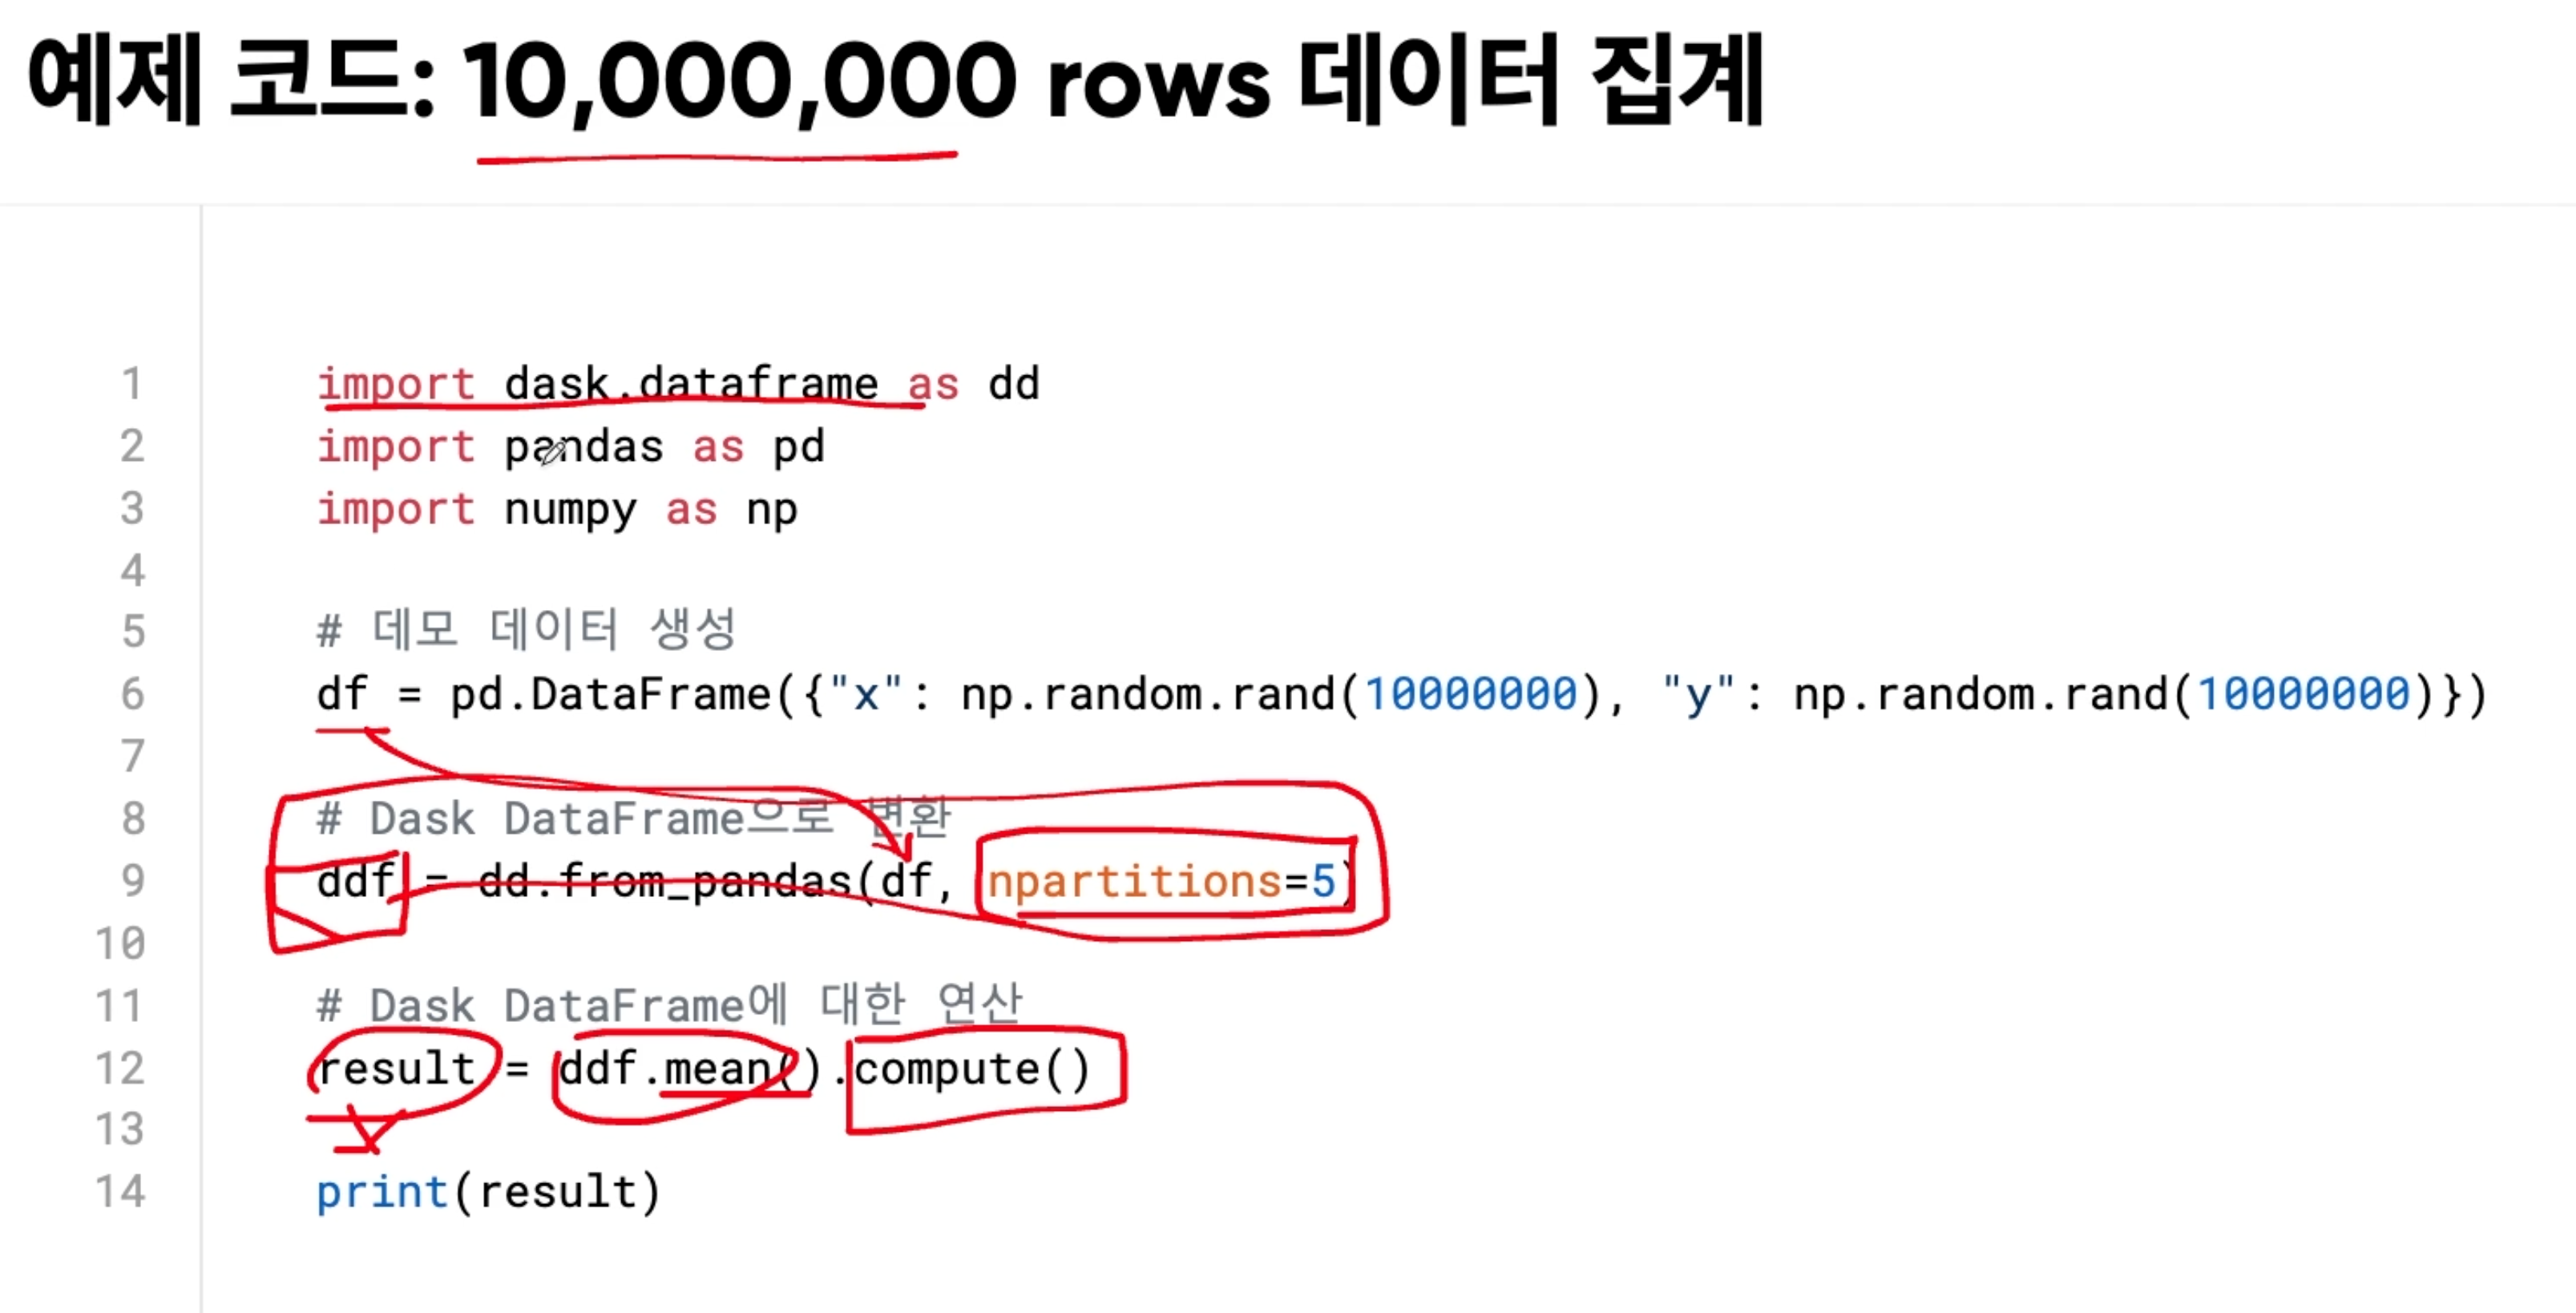